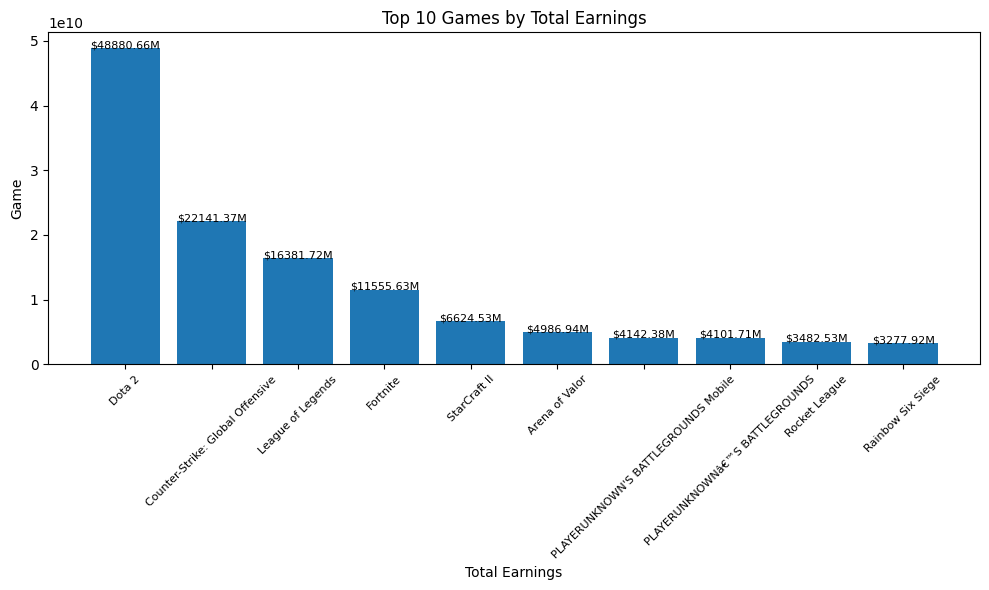

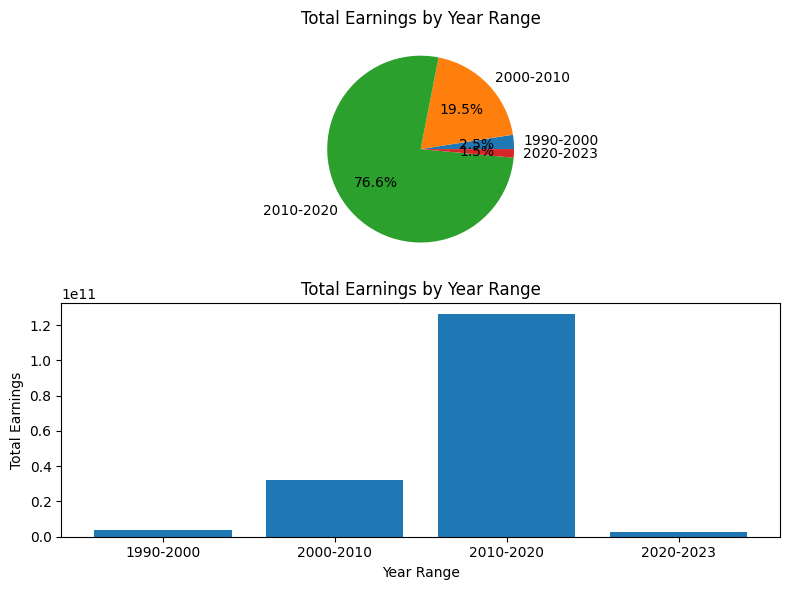

Game: Dota 2
Genre: Multiplayer Online Battle Arena
Total Earnings: 48880656253.200005
Earnings_YoY_Growth: 120386.65651973222
Players_YoY_Growth: 3808.712433666622
Tournaments_YoY_Growth: 4603.594285819094
Earnings by Year:
  Year: 2013
  Earnings: 48880656253.200005
Game: Counter-Strike: Global Offensive
Genre: First-Person Shooter
Total Earnings: 22141367982.53
Earnings_YoY_Growth: 9410.786805444974
Players_YoY_Growth: 1933.669728030114
Tournaments_YoY_Growth: 1196.9556983809136
Earnings by Year:
  Year: 2012
  Earnings: 22141367982.53
Game: League of Legends
Genre: Multiplayer Online Battle Arena
Total Earnings: 16381724667.36
Earnings_YoY_Growth: 85090.5559346755
Players_YoY_Growth: 6928.307057495338
Tournaments_YoY_Growth: 3682.820038582281
Earnings by Year:
  Year: 2009
  Earnings: 16381724667.36
Game: Fortnite
Genre: Battle Royale
Total Earnings: 11555634127.32
Earnings_YoY_Growth: 19008.081936513703
Players_YoY_Growth: 3889.34657822193
Tournaments_YoY_Growth: 3574.574276748569

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
df = pd.read_csv('predicted_results.csv')

# Convert "Date" and "ReleaseDate" columns to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

# Filter the DataFrame for games with total earnings over 10 million dollars
filtered_df = df[df['TotalEarnings'] > 10000000]

# Group by 'Game' and calculate the sum of selected columns for each game
grouped_df = filtered_df.groupby('Game')[['TotalEarnings', 'Earnings_YoY_Growth', 'Players_YoY_Growth', 'Tournaments_YoY_Growth']].sum().reset_index()

# Create a new column for the combined score (you can customize the formula based on your preference)
grouped_df['CombinedScore'] = grouped_df['TotalEarnings'] + grouped_df['Earnings_YoY_Growth'] + grouped_df['Players_YoY_Growth'] + grouped_df['Tournaments_YoY_Growth']

# Sort the grouped DataFrame by the combined score in descending order
sorted_df = grouped_df.sort_values(by='CombinedScore', ascending=False)

# Select the top 10 different games
top_10_games = sorted_df.head(10)

# Create a histogram of the top 10 games' total earnings
plt.figure(figsize=(10, 6))
plt.bar(top_10_games['Game'], top_10_games['TotalEarnings'])
plt.title('Top 10 Games by Total Earnings')
plt.xlabel('Total Earnings')
plt.ylabel('Game')

# Add labels to each bar
for i, (game, earnings) in enumerate(zip(top_10_games['Game'], top_10_games['TotalEarnings'])):
    plt.text(game, earnings, f"${earnings/1000000:.2f}M", ha='center', fontsize=8)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

# Extract the year from "ReleaseDate" and create a new column
df['Year'] = df['ReleaseDate'].dt.year

# Calculate the year-over-year growth in earnings, players, and tournaments
df['Earnings_YoY_Growth'] = df.groupby('Game')['TotalEarnings'].pct_change() + 1
df['Players_YoY_Growth'] = df.groupby('Game')['Players'].pct_change() + 1
df['Tournaments_YoY_Growth'] = df.groupby('Game')['Tournaments'].pct_change() + 1

# Filter the data based on the specified year ranges
year_ranges = [(1990, 2000), (2000, 2010), (2010, 2020), (2020, 2023)]
filtered_data = []
for start, end in year_ranges:
    filtered_data.append(df[(df['Year'] >= start) & (df['Year'] <= end)])

# Calculate the total earnings for each year range
earnings_by_year_range = [data['TotalEarnings'].sum() for data in filtered_data]

# Pie chart labels
labels = ['1990-2000', '2000-2010', '2010-2020', '2020-2023']

# Plotting the pie chart
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)  # First subplot for the pie chart
plt.pie(earnings_by_year_range, labels=labels, autopct='%1.1f%%')
plt.title('Total Earnings by Year Range')

plt.subplot(2, 1, 2)  # Second subplot for the bar graph
plt.bar(labels, earnings_by_year_range)
plt.title('Total Earnings by Year Range')
plt.xlabel('Year Range')
plt.ylabel('Total Earnings')

plt.tight_layout()  # Adjust the layout

plt.show()

# Create 'Genre' column from the existing one-hot encoded genre columns
genre_columns = [col for col in df.columns if 'Genre_' in col]
df['Genre'] = df[genre_columns].idxmax(axis=1).str.replace('Genre_', '')

# Encode the "Genre" column using one-hot encoding
encoder = OneHotEncoder()
encoded_genre = encoder.fit_transform(df['Genre'].values.reshape(-1, 1)).toarray()

# Create the encoded DataFrame
encoded_df = pd.concat([df, pd.DataFrame(encoded_genre, columns=encoder.categories_[0])], axis=1)

# Create categorical feature for release decade
df['Release_Decade'] = pd.cut(df['ReleaseDate'].dt.year, bins=range(1990, 2030, 10), labels=range(1990, 2020, 10))

# Split the data into training and testing sets
X = encoded_df.drop(['Game', 'ReleaseDate', 'Genre'], axis=1)
y = encoded_df['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Filter the DataFrame for games with total earnings over 10 million dollars
filtered_df = df[df['TotalEarnings'] > 10000000]

# Sort the filtered DataFrame by total earnings in descending order
sorted_df = filtered_df.sort_values(by='TotalEarnings', ascending=False)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Game', 'Genre', 'Total Earnings', 'Year', 'Earnings'])
for index, row in top_10_games.iterrows():
    game = row['Game']
    genre = df[df['Game'] == game]['Genre'].iloc[0]
    total_earnings = row['TotalEarnings']
    earnings_by_year = df[df['Game'] == game].groupby('Year')['TotalEarnings'].sum()
    
    for year, earnings in earnings_by_year.items():
        # Append the results to the DataFrame
        result = pd.DataFrame({'Game': [game], 'Genre': [genre], 'Total Earnings': [total_earnings], 'Year': [year], 'Earnings': [earnings]})
        results_df = pd.concat([results_df, result], ignore_index=True)
# Save the DataFrame to a CSV file
results_df.to_csv('results.csv', index=False)

for index, row in top_10_games.iterrows():
    print("Game:", row['Game'])
    print("Genre:", df[df['Game'] == row['Game']]['Genre'].iloc[0])  # Extract genre information
    print("Total Earnings:", row['TotalEarnings'])
    print("Earnings_YoY_Growth:", row['Earnings_YoY_Growth'])
    print("Players_YoY_Growth:", row['Players_YoY_Growth'])
    print("Tournaments_YoY_Growth:", row['Tournaments_YoY_Growth'])
    print("Earnings by Year:")
    earnings_by_year = df[df['Game'] == row['Game']].groupby('Year')['TotalEarnings'].sum()
    for year, earnings in earnings_by_year.items():
        print("  Year:", year)
        print("  Earnings:", earnings)



In [3]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('results.csv')

# Count the number of occurrences of each genre
genre_counts = df['Genre'].value_counts()

# Print the counts
for genre, count in genre_counts.items():
    print(f"Genre: {genre}, Count: {count}")


Genre: Multiplayer Online Battle Arena, Count: 3
Genre: Battle Royale, Count: 3
Genre: First-Person Shooter, Count: 2
Genre: Strategy, Count: 1
Genre: Sports, Count: 1


,Date,Game,Earnings,Players,Tournaments,ReleaseDate,Genre,TotalEarnings,TotalPlayers,TotalTournaments,Earnings_YoY_Growth,Players_YoY_Growth,Tournaments_YoY_Growth,Release_Decade
0,1998-01-01,Command and Conquer: Red Alert,15000.00,8,1,1996-01-01,Strategy,15000.00,8,1,778.156667,65.641341,25.097294,1990
1,1998-01-01,QuakeWorld,15000.00,8,1,1996-01-01,First-Person Shooter,105351.67,59,17,778.156667,65.641341,25.097294,1990
2,1998-05-01,Quake II,15000.00,4,1,1997-01-01,First-Person Shooter,130725.98,37,12,778.156667,65.641341,25.097294,1990
3,1998-05-01,Total Annihilation,15000.00,2,1,1997-01-01,Strategy,15000.00,2,1,778.156667,65.641341,25.097294,1990
4,1998-05-01,QuakeWorld,300.00,3,1,1996-01-01,First-Person Shooter,105351.67,59,17,-98.000000,-62.500000,0.000000,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,2023-10-01,osu!,1228.14,6,2,2007-01-01,Music / Rhythm Game,228205.84,854,205,-80.440298,-94.957983,-71.428571,2020
9240,2023-10-01,Trackmania (2020),873.60,11,3,2020-01-01,Racing,571463.36,732,622,-97.523934,-83.076923,-80.000000,2020
9241,2023-10-01,Age of Empires,614.90,8,1,1997-01-01,Strategy,510716.46,473,265,-71.924041,-80.000000,-50.000000,2020
9242,2023-10-01,Age of Empires II,490.01,12,3,1999-01-01,Strategy,3253232.59,1994,1613,-97.889467,-90.322581,-84.210526,2020


The Shape of X_train: (7395, 9)
The Shape of X_test: (1849, 9)
The Shape of y_train: (7395,)
The Shape of y_test: (1849,)
Training model...
Number of samples in the training set: 7395
Number of features: 9
Decision Tree Regressor trained.
Decision tree visualized and saved as 'decision_tree_gaming.png'.


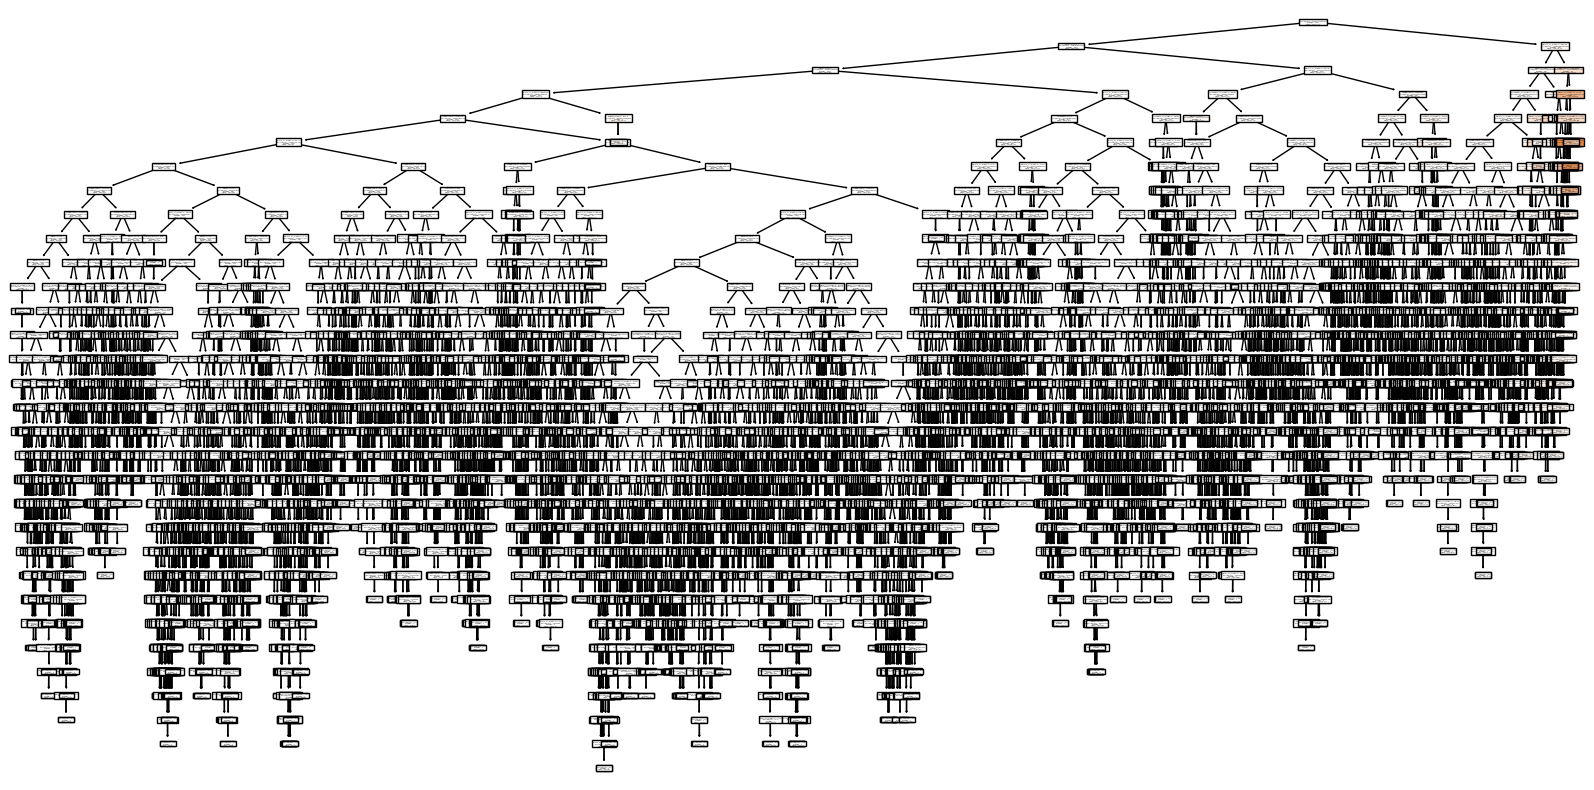

In [4]:
#Decision_Tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import tree

# Load the data from CSV file
df = pd.read_csv('data_creation_cleaned_no_duplicates.csv')
# Use display function to show the entire DataFrame
display(df)

# Drop non-numeric columns
X = df.drop(['Earnings', 'Date', 'ReleaseDate', 'Game', 'Genre'], axis=1)
y = df['Earnings']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a Decision Tree Regressor and fit it to the training data
regressor = DecisionTreeRegressor(random_state=0)

# Print information before training
print("The Shape of X_train:", X_train.shape)
print("The Shape of X_test:", X_test.shape)
print("The Shape of y_train:", y_train.shape)
print("The Shape of y_test:", y_test.shape)

print("Training model...")
print("Number of samples in the training set:", len(X_train))
print("Number of features:", len(X_train.columns))

# Train the model
regressor.fit(X_train, y_train)
print("Decision Tree Regressor trained.")

# Visualize the decision tree
fig = plt.figure(figsize=(20, 10))
_ = tree.plot_tree(regressor, feature_names=X.columns.tolist(), filled=True)

# Save the figure as a high-resolution image
fig.savefig('decision_tree_gaming.png', dpi=1000)
print("Decision tree visualized and saved as 'decision_tree_gaming.png'.")


In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('data_creation_cleaned_no_duplicates.csv')

# Select relevant features for regression
features = ['TotalEarnings', 'TotalPlayers', 'TotalTournaments', 'Earnings_YoY_Growth', 'Players_YoY_Growth', 'Tournaments_YoY_Growth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Earnings'], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_scaled, y_train)
linear_reg_predictions = linear_reg_model.predict(X_test_scaled)

# LASSO Regression
lasso_model = Lasso(alpha=0.01)  # You can adjust the alpha parameter
lasso_model.fit(X_train_scaled, y_train)
lasso_predictions = lasso_model.predict(X_test_scaled)

# Gradient Boosting Regression
gradient_boost_model = GradientBoostingRegressor()
gradient_boost_model.fit(X_train_scaled, y_train)
gradient_boost_predictions = gradient_boost_model.predict(X_test_scaled)

# Evaluate the models
linear_reg_rmse = mean_squared_error(y_test, linear_reg_predictions, squared=False)
lasso_rmse = mean_squared_error(y_test, lasso_predictions, squared=False)
gradient_boost_rmse = mean_squared_error(y_test, gradient_boost_predictions, squared=False)

print(f'Linear Regression RMSE: {linear_reg_rmse}')
print(f'LASSO Regression RMSE: {lasso_rmse}')
print(f'Gradient Boosting RMSE: {gradient_boost_rmse}')


Linear Regression RMSE: 903870.8150315287
LASSO Regression RMSE: 903870.8156255893
Gradient Boosting RMSE: 666445.3416571683


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv('data_creation_cleaned_no_duplicates.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create new columns for Year, Month, and Day
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop the original 'Date' column
df = df.drop('Date', axis=1)

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

# Define your target variables
targets = ['TotalEarnings', 'TotalPlayers', 'TotalTournaments', 'Earnings_YoY_Growth', 'Players_YoY_Growth', 'Tournaments_YoY_Growth']

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'Logistic Regression': LogisticRegression(max_iter=1000)  # Adjust the number of iterations as needed
}

# For each target, train the models and evaluate
for target in targets:
    print(f'Target: {target}')
    print('------------------------')
    
    X = df.drop(target, axis=1)
    y = df[target]

    # Binarize the target variable for logistic regression
    y_binary = (y > y.median()).astype(int)  # You can adjust the threshold as needed

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate logistic regression using classification metrics
        if name == 'Logistic Regression':
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            print(f'{name}:')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
        else:
            # For other regression models, calculate regression metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            print(f'{name}:')
            print(f'Mean Squared Error (MSE): {mse}')
            print(f'Root Mean Squared Error (RMSE): {rmse}')
            print(f'R-squared (R2): {r2}')

        print('------------------------')


Target: TotalEarnings
------------------------
Linear Regression:
Mean Squared Error (MSE): 0.0004652918419456858
Root Mean Squared Error (RMSE): 0.021570624514503187
R-squared (R2): 0.9981385925244436
------------------------
Gradient Boosting Regression:
Mean Squared Error (MSE): 0.02112295597848072
Root Mean Squared Error (RMSE): 0.14533738671959365
R-squared (R2): 0.9154972758607217
------------------------
Logistic Regression:
Accuracy: 0.8842617631151974
Precision: 0.929678188319428
Recall: 0.8342245989304813
F1 Score: 0.8793686583990982
------------------------
Target: TotalPlayers
------------------------
Linear Regression:
Mean Squared Error (MSE): 0.0003044253035805937
Root Mean Squared Error (RMSE): 0.01744778792800376
R-squared (R2): 0.9987821701918926
------------------------
Gradient Boosting Regression:
Mean Squared Error (MSE): 0.007219685691224232
Root Mean Squared Error (RMSE): 0.0849687336096298
R-squared (R2): 0.9711182075322743
------------------------
Logistic Reg